In [3]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [103]:
DATA_ROOT = Path('./data')

IMAGES_ROOT = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'car_masks'
SHADOW_DIR = DATA_ROOT / 'shadow_masks'

def load_image_and_masks(image_path):
    image_name = image_path.stem
    image = cv2.imread(image_path)
    mask = cv2.imread(MASKS_DIR / f'{image_name}.png', cv2.IMREAD_GRAYSCALE)
    shadow_mask = cv2.imread(SHADOW_DIR / f'{image_name}.png', cv2.IMREAD_GRAYSCALE)
    return image, mask, shadow_mask

def clean_mask(mask, kernel_size=7):
    _, mask = cv2.threshold(mask, 0.498, 1,cv2.THRESH_BINARY)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.medianBlur(mask, ksize=5)
    return mask

def extract_object_via_mask(image, mask):
    cleaned_mask = clean_mask(mask)
    extracted_obj_image = cv2.bitwise_and(image, image, mask=cleaned_mask)
    return extracted_obj_image

def detect_background(image, axis=1):
    # Check if the image has an alpha channel
    if image.shape[2] == 4:
        # Use alpha channel for detection
        non_transparent = image[:, :, 3] > 0
    else:
        # For RGB images, detect non-white pixels
        non_white = np.any(image != [255, 255, 255], axis=2)
    
    non_empty_rows = np.where(np.any(non_transparent if image.shape[2] == 4 else non_white, axis=axis))[0]
    if len(non_empty_rows) == 0:
        return None  # No ROI detected
    
    start_row = non_empty_rows[0]
    end_row = non_empty_rows[-1]
    
    return start_row, end_row

In [108]:
floor = cv2.imread('./data/floor.png', cv2.IMREAD_UNCHANGED)
wall = cv2.imread('./data/wall.png', cv2.IMREAD_UNCHANGED)
image = cv2.imread(IMAGES_ROOT/'1.jpeg')
mask = cv2.imread(MASKS_DIR/'1.png', cv2.IMREAD_GRAYSCALE)


print(floor.shape, wall.shape, image.shape, mask.shape)

(2160, 3840, 4) (2160, 3840, 4) (1095, 1460, 3) (1095, 1460)


In [109]:
start_row_floor, end_row_floor = detect_background(floor)
start_row_wall, end_row_wall = detect_background(wall)

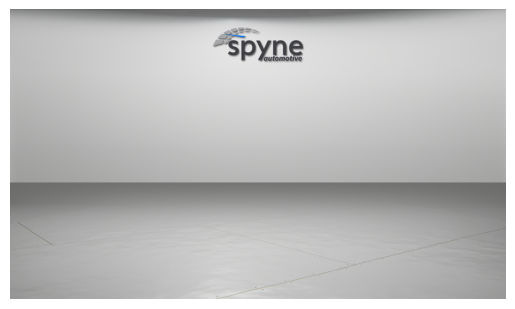

In [112]:
background = np.vstack([wall[end_row_wall-int(0.70*end_row_wall):end_row_wall, :], floor[start_row_floor:end_row_floor, :]])
plt.imshow(background)
plt.axis("off")
plt.show()

In [107]:
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
plt.imsave('background.jpeg', background)

In [96]:
image = cv2.imread(IMAGES_ROOT/'1.jpeg', cv2.IMREAD_UNCHANGED)
mask = cv2.imread(MASKS_DIR/'1.png', cv2.IMREAD_GRAYSCALE)

extracted_obj_image = extract_object_via_mask(image, mask)

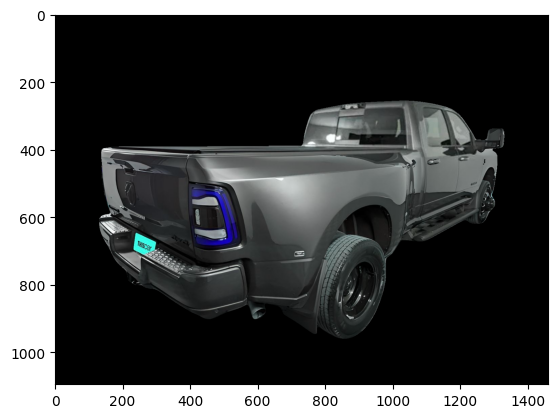

In [97]:
plt.imshow(extracted_obj_image)